In [1]:
from sklearn.svm import LinearSVC
from sklearn.pipeline import Pipeline
from sklearn.model_selection import cross_val_score, train_test_split
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import confusion_matrix, classification_report
import numpy as np
import joblib
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

Global configuration

In [3]:
TEST_SIZE = 0.2
RANDOM_SEED = 42 
MODEL_FILENAME = 'type_multimodal_gold.pkl'

COL_TITLE = 'Title'
COL_AUTHOR = 'Author'
COL_LOCATION = 'Location'
COL_DATE = 'Date'
COL_GENRE = 'Genre'
COL_TYPE_TARGET = 'Type'

Feature processing

In [5]:
title_transformer = TfidfVectorizer( # applies a transformer 
    ngram_range=(1, 2),
    max_df=0.7, # ignores words appearing in more than 70% of the corpus
    stop_words='english'
)

categorical_transformer = OneHotEncoder( # one-hot encoding for categorical metadata
    handle_unknown='ignore',
    sparse_output=False
)

numerical_transformer = StandardScaler() # standardizes numerical data

preprocessor = ColumnTransformer( # applies transformation on resepective columns
    transformers=[
        ('text', title_transformer, COL_TITLE),
        ('cat', categorical_transformer, [COL_AUTHOR, COL_LOCATION, COL_GENRE]),
        ('date', numerical_transformer, [COL_DATE])
    ],
    remainder='drop'
)

Load and prepare data

In [7]:
df = pd.read_csv('./data/training_data.csv')
df.dropna(
    subset=[COL_TYPE_TARGET, COL_TITLE, COL_AUTHOR, COL_LOCATION, COL_DATE, COL_GENRE],
    inplace=True
) # drop rows with missing values
X = df.drop(COL_TYPE_TARGET, axis=1) # features 
y = df[COL_TYPE_TARGET] # target label
print(f"Total usable samples: {len(y)}")

Total usable samples: 15091


Split into training and testing sets 

In [9]:
X_train, X_test, y_train, y_test = train_test_split( # shuffles and splits the data
    X,
    y,
    test_size=TEST_SIZE,
    random_state=RANDOM_SEED,
    stratify=y # keeps same proportion of genre in training and testing sets
)
print(f"Training samples: {len(y_train)}")
print(f"Testing samples : {len(y_test)}")

Training samples: 12072
Testing samples : 3019


Model pipeline

In [11]:
pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', LinearSVC(
        C=1.0,
        class_weight='balanced', # adjusts for genres that are not well represented
        random_state=RANDOM_SEED
    ))
])

Training phase

In [13]:
pipeline.fit(X_train, y_train)
print("Cross-validation (5-fold) on training set:")
cv_scores = cross_val_score(pipeline, X_train, y_train, cv=5) # divides the model in 5 folds and tests 5 times
print(f"Scores: {cv_scores}")
print(f"Mean CV accuracy: {cv_scores.mean():.4f}")

Cross-validation (5-fold) on training set:


/opt/anaconda3/lib/python3.12/site-packages/sklearn/svm/_base.py:1235: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/opt/anaconda3/lib/python3.12/site-packages/sklearn/svm/_base.py:1235: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


Scores: [0.91759834 0.90227743 0.91632146 0.91135046 0.90969345]
Mean CV accuracy: 0.9114


Testing phase

In [15]:
test_accuracy = pipeline.score(X_test, y_test)
print(f"Final test accuracy: {test_accuracy:.4f}")
y_pred = pipeline.predict(X_test) # predicts type for the test set

Final test accuracy: 0.9132


Classification report

In [17]:
print("Classification report:")
print(classification_report(y_test, y_pred, zero_division=0))

Classification report:
              precision    recall  f1-score   support

      ballad       0.94      0.85      0.89        20
      comedy       0.95      0.95      0.95        88
       elegy       1.00      0.83      0.91        18
        hymn       1.00      0.50      0.67         6
       lines       0.93      0.88      0.90        16
       lyric       1.00      0.73      0.85        15
      melody       1.00      0.60      0.75         5
       novel       0.85      0.94      0.89       557
         ode       0.94      0.90      0.92       115
       opera       0.89      0.98      0.93        51
   pantomime       1.00      0.75      0.86         4
       parod       0.00      0.00      0.00         2
    pastoral       0.86      0.86      0.86         7
        play       0.94      0.99      0.96       103
        poet       0.89      0.95      0.92       511
  recitation       1.00      0.50      0.67         6
       rhyme       1.00      0.94      0.97        16
    

Normalized confusion matrix

In [19]:
labels = pipeline.classes_
cm_norm = confusion_matrix(
    y_test,
    y_pred,
    labels=labels,
    normalize='true'
)
cm_df = pd.DataFrame(cm_norm, index=labels, columns=labels)
print("Normalized confusion matrix (rows = true labels):")
print(cm_df.round(2))

Normalized confusion matrix (rows = true labels):
            ballad  comedy  elegy  hymn  lines  lyric  melody  novel   ode  \
ballad        0.85    0.00   0.00   0.0   0.00   0.00     0.0   0.00  0.00   
comedy        0.00    0.95   0.00   0.0   0.00   0.00     0.0   0.00  0.00   
elegy         0.00    0.00   0.83   0.0   0.00   0.00     0.0   0.00  0.00   
hymn          0.00    0.00   0.00   0.5   0.00   0.00     0.0   0.00  0.00   
lines         0.00    0.00   0.00   0.0   0.88   0.00     0.0   0.00  0.00   
lyric         0.07    0.00   0.00   0.0   0.00   0.73     0.0   0.00  0.07   
melody        0.00    0.00   0.00   0.0   0.00   0.00     0.6   0.00  0.00   
novel         0.00    0.00   0.00   0.0   0.00   0.00     0.0   0.94  0.00   
ode           0.00    0.00   0.00   0.0   0.00   0.00     0.0   0.00  0.90   
opera         0.00    0.00   0.00   0.0   0.00   0.00     0.0   0.02  0.00   
pantomime     0.00    0.00   0.00   0.0   0.00   0.00     0.0   0.00  0.00   
parod         

Plot the confusion matrix

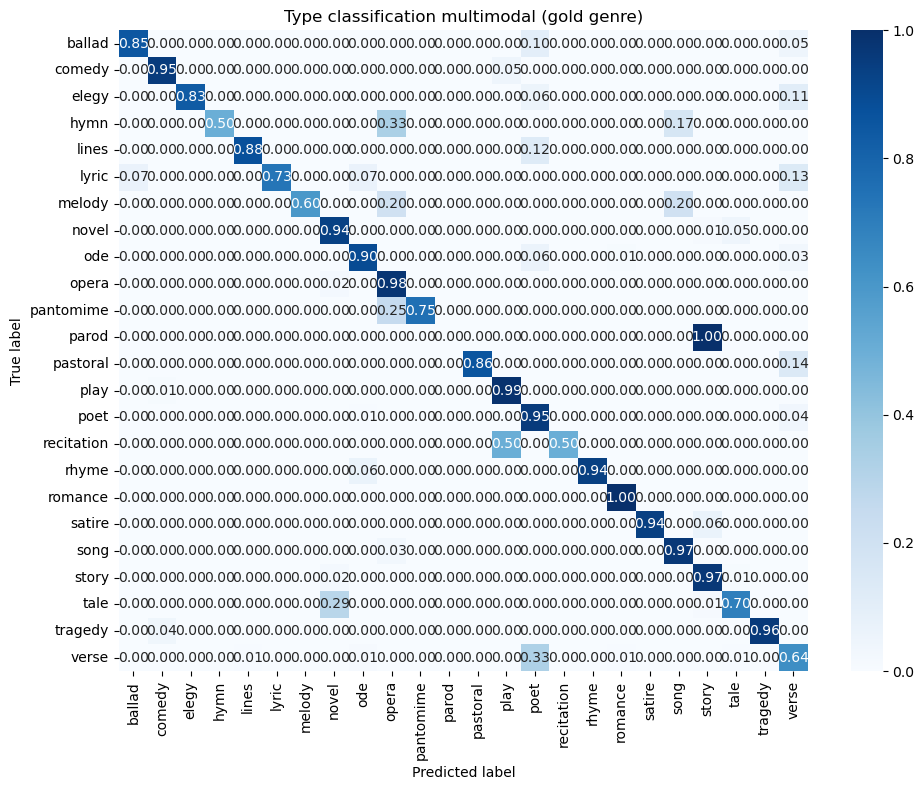

In [21]:
plt.figure(figsize=(10, 8))
sns.heatmap(cm_df, annot=True, fmt=".2f", cmap="Blues")
plt.ylabel("True label")
plt.xlabel("Predicted label")
plt.title("Type classification multimodal (gold genre)")
plt.tight_layout()
plt.show()

Uncertainty measures, based on SVM decisions margin

In [23]:
decision_scores = pipeline.decision_function(X_test) # gets decision score for each class
sorted_scores = np.sort(decision_scores, axis=1)
margins = sorted_scores[:, -1] - sorted_scores[:, -2] # margin uncertainty = difference between the highest and second highest score 
uncertainty_df = pd.DataFrame({
    "true_label": y_test.values,
    "predicted_label": y_pred,
    "margin": margins
}).sort_values("margin")
print("Most uncertain predictions (lowest margins):")
print(uncertainty_df.head(10))

Most uncertain predictions (lowest margins):
     true_label predicted_label    margin
495        poet           verse  0.000585
2840        ode             ode  0.000746
876        poet            poet  0.002900
2413   pastoral        pastoral  0.003523
1497      story           story  0.003739
1263      verse           verse  0.005397
1853       poet            poet  0.009212
2416      verse            poet  0.009747
2700       poet           verse  0.013157
1611      novel           novel  0.013581


Plot the uncertainy measures 

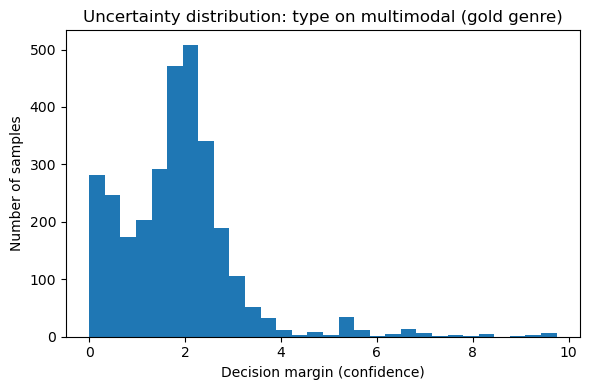

In [25]:
plt.figure(figsize=(6, 4))
plt.hist(margins, bins=30)
plt.xlabel("Decision margin (confidence)")
plt.ylabel("Number of samples")
plt.title("Uncertainty distribution: type on multimodal (gold genre)")
plt.tight_layout()
plt.show()

Save the model

In [27]:
joblib.dump(pipeline, MODEL_FILENAME)
print(f"Model saved to: {MODEL_FILENAME}")

Model saved to: type_multimodal_gold.pkl
